# Correlation Power Analysis (CPA)

This more powerful attack allows to quickly retrieve keys. You will use datasets already acquired in DPA lab session and demonstrate that CPA is indeed much faster, that it requires fewer traces. 

## Set-up + Data sets

### Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt 
import time

from tqdm import tnrange

In [2]:
# AES SBOX as an array
SBOX = np.array([
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5,
    0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0,
    0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc,
    0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a,
    0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0,
    0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b,
    0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85,
    0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5,
    0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17,
    0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88,
    0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c,
    0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9,
    0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6,
    0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e,
    0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94,
    0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68,
    0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16], dtype=np.int)

 ### Load and select datasets on which you will work

In [4]:
# load traces
traces_exp = np.load("./acqui/tracesAES.npy")
plaintexts_exp = np.load("./acqui/plaintexts.npy")

#traces_simu = np.load("./simu/traces_simu.npy")
#plaintexts_simu  = np.load("./simu/plaintexts.npy")

In [6]:
# traces = traces_simu
# messages = plaintexts_simu
traces = traces_exp
messages = plaintexts_exp

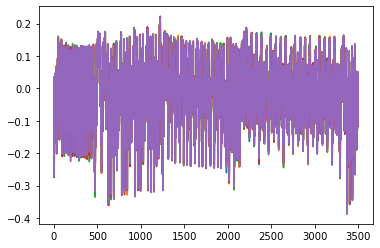

In [8]:
plt.plot(traces_exp[:5].T)
plt.show()

In [9]:
print(plaintexts_exp[:5])

[[162  57  16  68 195  82  55 198 205 215 167 189 206  10  37 129]
 [ 12 150 177  79 147  93  37 150  10 202 233 111 142  53 220 140]
 [204 183  90  91  83   2  89 140  87 174  23  93  24 251 108 223]
 [114  72   6 189   6 175  80 238  35  51 190 252  90  29 215   6]
 [177  90  39 174 231  41 200 158  60 167  59 181 134  22 223  45]]


## CPA  implementation

CPA measures the correlation between a specific expected/theoretical model and the actual/experimental traces. For a given key guess, the higher the correlation, the more likely the key guess is. As in DPA attack, we will work byte by byte (divide and conquer strategy) and target the same output (after the first SBox).

The figure belows shows the principle and steps of this attack.
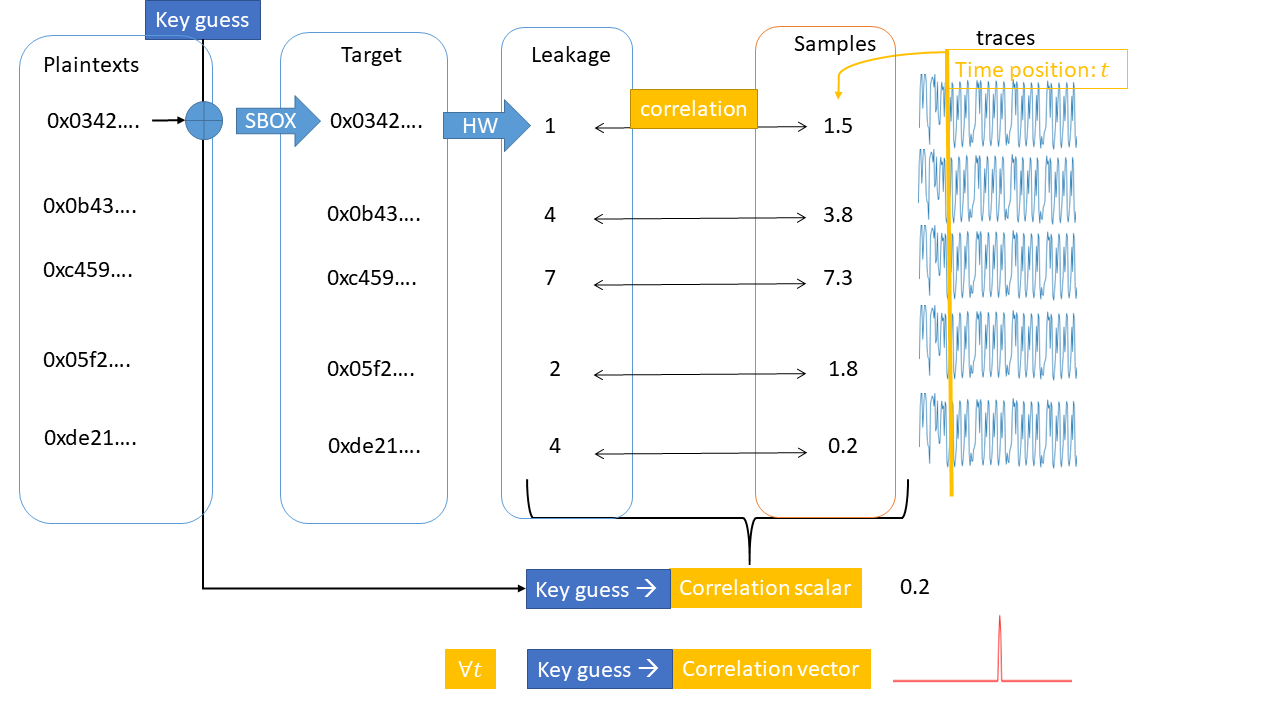

###  Hamming weight leakage model

In this lab, we will use the hamming weight leakage which is the more common leakage model. 
1. Define the `hamming_weight` function which outputs the number of "1" in the binary reprensentation of a number. 


In [10]:
def hamming_weight(x):
    return bin(x).count("1")

Sanity checks

In [11]:
assert(hamming_weight(0b10111011) == 6)
assert(hamming_weight(0x55) == 4)

2. Define `sel_hamming` which returns the hamming_weight of the target, i.e. HW of the ouput of the first SBox, with a known `message` (16 bytes) , key `guess` (1 single byte) for a specific `byte` position (from 0 to 15).

In [12]:
def sel_hamming(message, guess, byte):
    # a single byte
    return hamming_weight(SBOX[message[byte] ^ guess])

In [13]:
assert(sel_hamming(messages[0], 0, 0) == 3)
assert(sel_hamming(messages[2], 0x65, 4) == 5)

AssertionError: 

Now you can calculate this hamming weight for all the messages and obtain the vector at the right hand side of the CPA schematics=. 

2. Calulate the value of the leakage model vector for all the messages for a given key guess. 


In [45]:
def leakage_model(messages, guess, byte):
    return np.array([sel_hamming(message, guess, byte) for message in messages])

### Correlation

CPA measures the correlation between experiments and the leakage model. We will first implement this correlation at one time position and then extrapolates this correlation for all time samples. 

#### correlation coefficient of 2 vectors

We will use Pearson `correlation` coefficient to measure the correlation between 2 vectors of lenght $N$,  $X = \sum_i X_i$ and $Y = \sum_i Y_i$. This coefficient corresponds to a normalized covariance of the 2 vectors:

$$ corr = \frac{cov(X, Y)} {\sigma_X \sigma_Y} $$

where 

$$ \sigma_X = \sqrt{var(X)} =  \sqrt{\sum_i (X_i - \bar{X})^2}$$ where $$  X = 1/N \sum_{i=0}^{N-1} X_i $$
and 

$$ cov(X, Y) = \sum_i (X_i - \bar{X})(Y_i - \bar{Y})  $$

You can use numpy functions `np.mean`, `np.var`, `np.sqrt` to calculate the corr coefficient as they are faster and optimized for vectors. 

In [46]:
def corr(xv, yv):
    ''' xv, yv vectors
    returns scalar, correlation coefficient of the two vectors
    '''
    # cov = np.cov(xv, yv, bias=True)
    # sigmax = np.sqrt(np.var(xv))
    # sigmay = np.sqrt(np.var(yv))
    # return (cov / (sigmax * sigmay))[0,1]

    mean_xv = np.mean(xv)
    mean_yv = np.mean(yv)
    std_xv = np.std(xv)
    std_yv = np.std(yv)
    
    return ((xv - mean_xv) * (yv - mean_yv)).mean() / (std_xv * std_yv)

1.0
0.9999999999999999


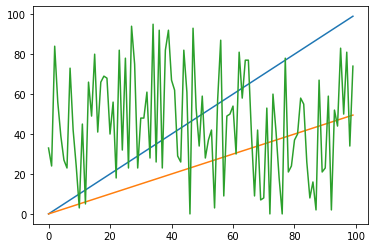

In [47]:
a = np.arange(100)
b = 0.5 * np.arange(100)
c = np.random.randint(0, 100, 100)
print(corr(a, b))
print(np.corrcoef(a, b)[0, 1])

assert(corr(a, b) == 1)
assert(corr(a, c) < 0.2)

plt.figure()
plt.plot(a)
plt.plot(b)
plt.plot(c)
plt.show()

### Correlation between traces and leakage model

Calculate the correlation function at time position 18, for byte 0 in the simulated traces for all possible key guesses, and retrieve the correct key. This corresponds to the leakage scalar in the CPA figure. 


In [48]:
def correlation(guess, time_pos, byte):
    return corr(traces[:, time_pos], leakage_model(messages, guess, byte))

In [49]:
def correlation_guesses(guesses, time_pos, byte):
    return np.array([correlation(guess, time_pos, byte) for guess in guesses]) # a vector of correlation for every key guesses

In [50]:
print("Correct key byte is ", correlation_guesses(np.arange(256), 6, 0).argmax())

Correct key byte is  190


In order to finish the correlation vector we will need to calculate this correlation vector for all time position. You could do this with a loop but we would better use numpy acceleration and use the same functions with an axis parameters. 

For instance `traces.sum(axis=0)` will calculate the mean value of the columns of the traces, which correponds to the mean value at a given time position. This is what we need. The only issue might be the leakage model vector which is not a matrix, but youn can convert it to a matrix by returning an np.array of leakage model. 

In [171]:
def corr_vect(xmat, ymat):
    ''' xmat, ymat
    returns vector correlation coefficient of the two matrices
    '''
    mean_xmat = np.mean(xmat, axis=0)
    mean_ymat = np.mean(ymat, axis=0)
    std_xmat = np.std(xmat, axis=0)
    std_ymat = np.std(ymat, axis=0)
    
    return ((xmat - mean_xmat) * (ymat - mean_ymat)).mean(axis=0) / (std_xmat * std_ymat)

In [180]:
def guess_correlation(guess, messages, traces, leakage_fnct):
    # for every time positions and a specific guess
    leakage = np.array(leakage_fnct(messages, guess))
    leakages = np.tile(leakage, (traces.shape[1], 1)).transpose()
    
    # we can get negative values with corr_vect ([-1, 1]), so use np.abs() to be able to use argmax
    # when looking for the good key.
    # the peaks are also more visible after np.abs(), however the computation is quite longer
    return np.abs(corr_vect(traces, leakages))


Sanity plot checks

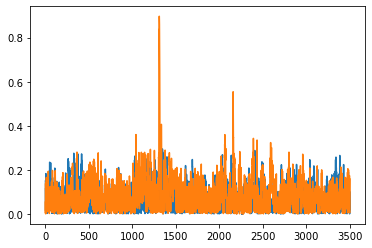

In [181]:
nb_traces = 100
res = guess_correlation(0, messages[:nb_traces,:], traces[:nb_traces,:], lambda m,g :leakage_model(m, g, 0))
plt.plot(res)

# 0x61 -> 0xc1 for traces_exp
res = guess_correlation(0xc1, messages[:nb_traces,:], traces[:nb_traces,:], lambda m,g :leakage_model(m, g, 0))
plt.plot(res)
plt.show()

### CPA result
Return the CPA matrix, which corresponds to guess_correlation for every key guesses, like DPA matrix.
Determine the key. 

Index : 0
Index : 1
Index : 2
Index : 3
Index : 4
Index : 5
Index : 6
Index : 7
Index : 8
Index : 9
Index : 10
Index : 11
Index : 12
Index : 13
Index : 14
Index : 15
Index : 16
Index : 17
Index : 18
Index : 19
Index : 20
Index : 21
Index : 22
Index : 23
Index : 24
Index : 25
Index : 26
Index : 27
Index : 28
Index : 29
Index : 30
Index : 31
Index : 32
Index : 33
Index : 34
Index : 35
Index : 36
Index : 37
Index : 38
Index : 39
Index : 40
Index : 41
Index : 42
Index : 43
Index : 44
Index : 45
Index : 46
Index : 47
Index : 48
Index : 49
Index : 50
Index : 51
Index : 52
Index : 53
Index : 54
Index : 55
Index : 56
Index : 57
Index : 58
Index : 59
Index : 60
Index : 61
Index : 62
Index : 63
Index : 64
Index : 65
Index : 66
Index : 67
Index : 68
Index : 69
Index : 70
Index : 71
Index : 72
Index : 73
Index : 74
Index : 75
Index : 76
Index : 77
Index : 78
Index : 79
Index : 80
Index : 81
Index : 82
Index : 83
Index : 84
Index : 85
Index : 86
Index : 87
Index : 88
Index : 89
Index : 90
Index : 9

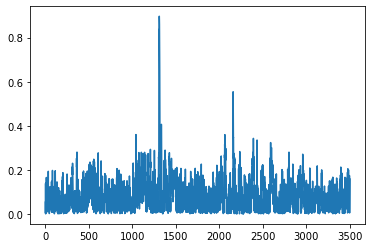

In [183]:
def cpa(guesses, messages, traces, model_fnct):
    matrix = np.zeros((256, len(traces[0])), dtype = np.float64)
    
    for index, key_guess in enumerate(guesses):
        print(f"Key guess : {key_guess}")
        matrix[index] = guess_correlation(key_guess, messages, traces, model_fnct)
    
    return matrix


# correct_key returns the indexes of the max in dpa_out
correct_key = lambda cpa_out: np.unravel_index(np.argmax(cpa_out, axis=None), cpa_out.shape)
cpa_out = cpa(np.arange(256), messages, traces, lambda m,g :leakage_model(m, g, 0))
print("Correct key byte is ", cpa_out.max(1).argmax(), correct_key(cpa_out))

plt.plot(res.T)
plt.show()

Determine all the key bytes.

In [185]:
key_list = []
time_pos = []

for pos in range(16):
    key_byte, time = correct_key(cpa(np.arange(256), messages, traces, lambda m, g :leakage_model(m, g, pos)))
    key_list.append(key_byte)
    time_pos.append(time)
    print("key_"+ str(pos) + " = " + str(bytearray(key_list)))

Index : 0
Index : 1
Index : 2
Index : 3
Index : 4
Index : 5
Index : 6
Index : 7
Index : 8
Index : 9
Index : 10
Index : 11
Index : 12
Index : 13
Index : 14
Index : 15
Index : 16
Index : 17
Index : 18
Index : 19
Index : 20
Index : 21
Index : 22
Index : 23
Index : 24
Index : 25
Index : 26
Index : 27
Index : 28
Index : 29
Index : 30
Index : 31
Index : 32
Index : 33
Index : 34
Index : 35
Index : 36
Index : 37
Index : 38
Index : 39
Index : 40
Index : 41
Index : 42
Index : 43
Index : 44
Index : 45
Index : 46
Index : 47
Index : 48
Index : 49
Index : 50
Index : 51
Index : 52
Index : 53
Index : 54
Index : 55
Index : 56
Index : 57
Index : 58
Index : 59
Index : 60
Index : 61
Index : 62
Index : 63
Index : 64
Index : 65
Index : 66
Index : 67
Index : 68
Index : 69
Index : 70
Index : 71
Index : 72
Index : 73
Index : 74
Index : 75
Index : 76
Index : 77
Index : 78
Index : 79
Index : 80
Index : 81
Index : 82
Index : 83
Index : 84
Index : 85
Index : 86
Index : 87
Index : 88
Index : 89
Index : 90
Index : 9

Index : 194
Index : 195
Index : 196
Index : 197
Index : 198
Index : 199
Index : 200
Index : 201
Index : 202
Index : 203
Index : 204
Index : 205
Index : 206
Index : 207
Index : 208
Index : 209
Index : 210
Index : 211
Index : 212
Index : 213
Index : 214
Index : 215
Index : 216
Index : 217
Index : 218
Index : 219
Index : 220
Index : 221
Index : 222
Index : 223
Index : 224
Index : 225
Index : 226
Index : 227
Index : 228
Index : 229
Index : 230
Index : 231
Index : 232
Index : 233
Index : 234
Index : 235
Index : 236
Index : 237
Index : 238
Index : 239
Index : 240
Index : 241
Index : 242
Index : 243
Index : 244
Index : 245
Index : 246
Index : 247
Index : 248
Index : 249
Index : 250
Index : 251
Index : 252
Index : 253
Index : 254
Index : 255
key_2 = bytearray(b'\xc1^\xc0')
Index : 0
Index : 1
Index : 2
Index : 3
Index : 4
Index : 5
Index : 6
Index : 7
Index : 8
Index : 9
Index : 10
Index : 11
Index : 12
Index : 13
Index : 14
Index : 15
Index : 16
Index : 17
Index : 18
Index : 19
Index : 20
Ind

Index : 128
Index : 129
Index : 130
Index : 131
Index : 132
Index : 133
Index : 134
Index : 135
Index : 136
Index : 137
Index : 138
Index : 139
Index : 140
Index : 141
Index : 142
Index : 143
Index : 144
Index : 145
Index : 146
Index : 147
Index : 148
Index : 149
Index : 150
Index : 151
Index : 152
Index : 153
Index : 154
Index : 155
Index : 156
Index : 157
Index : 158
Index : 159
Index : 160
Index : 161
Index : 162
Index : 163
Index : 164
Index : 165
Index : 166
Index : 167
Index : 168
Index : 169
Index : 170
Index : 171
Index : 172
Index : 173
Index : 174
Index : 175
Index : 176
Index : 177
Index : 178
Index : 179
Index : 180
Index : 181
Index : 182
Index : 183
Index : 184
Index : 185
Index : 186
Index : 187
Index : 188
Index : 189
Index : 190
Index : 191
Index : 192
Index : 193
Index : 194
Index : 195
Index : 196
Index : 197
Index : 198
Index : 199
Index : 200
Index : 201
Index : 202
Index : 203
Index : 204
Index : 205
Index : 206
Index : 207
Index : 208
Index : 209
Index : 210
Inde

Index : 56
Index : 57
Index : 58
Index : 59
Index : 60
Index : 61
Index : 62
Index : 63
Index : 64
Index : 65
Index : 66
Index : 67
Index : 68
Index : 69
Index : 70
Index : 71
Index : 72
Index : 73
Index : 74
Index : 75
Index : 76
Index : 77
Index : 78
Index : 79
Index : 80
Index : 81
Index : 82
Index : 83
Index : 84
Index : 85
Index : 86
Index : 87
Index : 88
Index : 89
Index : 90
Index : 91
Index : 92
Index : 93
Index : 94
Index : 95
Index : 96
Index : 97
Index : 98
Index : 99
Index : 100
Index : 101
Index : 102
Index : 103
Index : 104
Index : 105
Index : 106
Index : 107
Index : 108
Index : 109
Index : 110
Index : 111
Index : 112
Index : 113
Index : 114
Index : 115
Index : 116
Index : 117
Index : 118
Index : 119
Index : 120
Index : 121
Index : 122
Index : 123
Index : 124
Index : 125
Index : 126
Index : 127
Index : 128
Index : 129
Index : 130
Index : 131
Index : 132
Index : 133
Index : 134
Index : 135
Index : 136
Index : 137
Index : 138
Index : 139
Index : 140
Index : 141
Index : 142


Index : 241
Index : 242
Index : 243
Index : 244
Index : 245
Index : 246
Index : 247
Index : 248
Index : 249
Index : 250
Index : 251
Index : 252
Index : 253
Index : 254
Index : 255
key_10 = bytearray(b'\xc1^\xc0\x15\xde\xc0\xde\xd0\xca\xfe\xde')
Index : 0
Index : 1
Index : 2
Index : 3
Index : 4
Index : 5
Index : 6
Index : 7
Index : 8
Index : 9
Index : 10
Index : 11
Index : 12
Index : 13
Index : 14
Index : 15
Index : 16
Index : 17
Index : 18
Index : 19
Index : 20
Index : 21
Index : 22
Index : 23
Index : 24
Index : 25
Index : 26
Index : 27
Index : 28
Index : 29
Index : 30
Index : 31
Index : 32
Index : 33
Index : 34
Index : 35
Index : 36
Index : 37
Index : 38
Index : 39
Index : 40
Index : 41
Index : 42
Index : 43
Index : 44
Index : 45
Index : 46
Index : 47
Index : 48
Index : 49
Index : 50
Index : 51
Index : 52
Index : 53
Index : 54
Index : 55
Index : 56
Index : 57
Index : 58
Index : 59
Index : 60
Index : 61
Index : 62
Index : 63
Index : 64
Index : 65
Index : 66
Index : 67
Index : 68
Index 

Index : 167
Index : 168
Index : 169
Index : 170
Index : 171
Index : 172
Index : 173
Index : 174
Index : 175
Index : 176
Index : 177
Index : 178
Index : 179
Index : 180
Index : 181
Index : 182
Index : 183
Index : 184
Index : 185
Index : 186
Index : 187
Index : 188
Index : 189
Index : 190
Index : 191
Index : 192
Index : 193
Index : 194
Index : 195
Index : 196
Index : 197
Index : 198
Index : 199
Index : 200
Index : 201
Index : 202
Index : 203
Index : 204
Index : 205
Index : 206
Index : 207
Index : 208
Index : 209
Index : 210
Index : 211
Index : 212
Index : 213
Index : 214
Index : 215
Index : 216
Index : 217
Index : 218
Index : 219
Index : 220
Index : 221
Index : 222
Index : 223
Index : 224
Index : 225
Index : 226
Index : 227
Index : 228
Index : 229
Index : 230
Index : 231
Index : 232
Index : 233
Index : 234
Index : 235
Index : 236
Index : 237
Index : 238
Index : 239
Index : 240
Index : 241
Index : 242
Index : 243
Index : 244
Index : 245
Index : 246
Index : 247
Index : 248
Index : 249
Inde

In [186]:
key = bytearray(key_list).hex()
print(f"Key : {key}")
print(f"Time positions : {time_pos}")

Key : c15ec015dec0ded0cafedeadbeef00ff
Time positions : [1310, 1486, 1662, 1838, 1349, 2042, 1701, 1878, 1390, 1566, 1742, 1918, 1429, 1606, 1782, 1958]


# Comparison with DPA

The goal is to compare 2 different type of attacks and assess the fastest. Choose a byte to attack and determine how many curves are needed for CPA and for DPA to retrive this key byte.

The best way to illustrate the two attacks is to plot the correct key rank versus number of curves;

## Rank CPA



In [193]:
def rank_cpa_byte(key, key_byte_index, traces, messages):
    cpa_out = cpa(np.arange(256), messages, traces, lambda m, g :leakage_model(m, g, key_byte_index))
    # find the max of each line (256 lines), sort the result and get the sort index
    ranks = np.argsort(np.max(cpa_out, axis=1))[::-1]
    assert len(ranks) == 256
    # print(ranks)
    rank_key_byte = np.where(ranks==key[key_byte_index])
    assert len(rank_key_byte[0]) == 1
    # print(rank_key_byte, key[key_byte_index])
    # print(ranks[rank_key_byte[0][0]])
    
    return rank_key_byte[0][0]

# number of keys that have a higher probability than k
# return an array
def rank_cpa(key, nb_traces, traces, messages):
    rank = 0
    for key_byte_index in range(16):
        rank += rank_cpa_byte(key, key_byte_index, traces, messages)

    return rank / 16


# test with random key and not enough traces
key = np.random.randint(low=0, high=256, size=16, dtype=np.uint8) 
rank = rank_cpa_byte(key, 0, traces[:20,:], messages[:20,:])
print(f"Key : {key}, Rank : {rank}")

# test with the correct key and all available traces
key = bytearray(key_list)
rank = rank_cpa_byte(key, 0, traces, messages)
print(f"Key : {key.hex()}, Rank : {rank}")

Index : 0
Index : 1
Index : 2
Index : 3
Index : 4
Index : 5
Index : 6
Index : 7
Index : 8
Index : 9
Index : 10
Index : 11
Index : 12
Index : 13
Index : 14
Index : 15
Index : 16
Index : 17
Index : 18
Index : 19
Index : 20
Index : 21
Index : 22
Index : 23
Index : 24
Index : 25
Index : 26
Index : 27
Index : 28
Index : 29
Index : 30
Index : 31
Index : 32
Index : 33
Index : 34
Index : 35
Index : 36
Index : 37
Index : 38
Index : 39
Index : 40
Index : 41
Index : 42
Index : 43
Index : 44
Index : 45
Index : 46
Index : 47
Index : 48
Index : 49
Index : 50
Index : 51
Index : 52
Index : 53
Index : 54
Index : 55
Index : 56
Index : 57
Index : 58
Index : 59
Index : 60
Index : 61
Index : 62
Index : 63
Index : 64
Index : 65
Index : 66
Index : 67
Index : 68
Index : 69
Index : 70
Index : 71
Index : 72
Index : 73
Index : 74
Index : 75
Index : 76
Index : 77
Index : 78
Index : 79
Index : 80
Index : 81
Index : 82
Index : 83
Index : 84
Index : 85
Index : 86
Index : 87
Index : 88
Index : 89
Index : 90
Index : 9

In [194]:
print(rank)
print(f"Key : {key.hex()}, Rank : {rank}")

0
Key : c15ec015dec0ded0cafedeadbeef00ff, Rank : 0


## Compare with DPA

Copy the DPA function from previous lab to get the correct key rank wih respect to the number of traces. 

In [195]:
# returns the output values after the first SBOX 
def target_function(msg, key, byte_i):
    ''' msg: 16 byte AES plaintext
        key: 16 bytes AES key
        byte_i:  byte position
        returns: 1 byte at the output of first SBOX
    '''
    return SBOX[msg ^ key][byte_i]


# returns the value of bit_j of a byte
def leakage_function(byte_i, bit_j):
    ''' byte: 
        bit: 
        returns: 0/1 
    '''
    return (byte_i >> bit_j) & 1  


def selection(msg, key, byte_i, bit_j):
    ''' mess: message/plaintext
     key : key
     byte_n : the targeted byte
     bit_n : the targeted bit in the byte
     returns 0/1 
    '''
    return leakage_function(target_function(msg, key, byte_i), bit_j)


# sel0 is selection  with bit_j = 0 
# this function will be used fo further attacks
def sel0(msg, key, byte_i):
    return selection(msg, key, byte_i, 0)


def hypothesis(guess, messages, traces, selection_function):
    '''
    guess: key for this hypothesis
    messages: vector of n values 
    traces: matrix of traces (n . t)
    selection_function: a funtion which takes (m, k) as inputs and returns (0,1). You can use a lambda function derived from 
        the sel0 function
    returns hypothesis(vector)
    '''
    h_0 = np.zeros(len(traces[0]), dtype = np.float64)
    h_1 = np.zeros(len(traces[0]), dtype = np.float64)
    
    h_0_count = 0
    h_1_count = 0
    for trace, message in zip(traces, messages):
        bit = selection_function(message, guess)
        if bit:
            h_1 += trace
            h_1_count += 1
        else:
            h_0 += trace
            h_0_count += 1
    
    # check if one set is empty to avoid divide by zero errors
    if h_0_count == 0:
        mean_0 = 0
    else:
        mean_0 = (h_0 / h_0_count)
        
    if h_1_count == 0:
        mean_1 = 0
    else:
        mean_1 = (h_1 / h_1_count)
    
    # return the difference of the two sets ie. abs(mean(h_0) - mean(h_1))
    return np.abs(mean_0 - mean_1)


def dpa(guesses, messages, traces, selection_function):
    matrix = np.zeros((256, len(traces[0])), dtype = np.float64)
    
    for index, key_guess in enumerate(guesses):
        matrix[index] = hypothesis(key_guess, messages, traces, selection_function)
    
    return matrix  # matrix of 256 hypothesis vectors


def rank_dpa_byte(key, key_byte_index, traces, messages):
    dpa_out = dpa(range(0, 256), messages, traces, lambda m, g: sel0(m, g, key_byte_index))
    # find the max of each line (256 lines), sort the result and get the sort index
    ranks = np.argsort(np.max(dpa_out, axis=1))[::-1]
    assert len(ranks) == 256
    # print(ranks)
    rank_key_byte = np.where(ranks==key[key_byte_index])
    assert len(rank_key_byte[0]) == 1
    # print(rank_key_byte, key[key_byte_index])
    # print(ranks[rank_key_byte[0][0]])
    
    return rank_key_byte[0][0]

# number of keys that have a higher probability than k
# return an array
def rank_dpa(key, nb_traces, traces, messages):
    rank = 0
    for key_byte_index in range(16):
        rank += rank_dpa_byte(key, key_byte_index, traces, messages)

    return rank / 16


# test with random key and not enough traces
key = np.random.randint(low=0, high=256, size=16, dtype=np.uint8) 
rank = rank_dpa_byte(key, 0, traces[:20,:], messages[:20,:])
print(f"Key : {key}, Rank : {rank}")

# test with the correct key and all available traces
key = bytearray(key_list)
rank = rank_dpa_byte(key, 0, traces, messages)
assert rank == 0
print(f"Key : {key.hex()}, Rank : {rank}")

Key : [246 131  46  45  11 224  55  91  67   8   4  39 200 251 224  12], Rank : 227
Key : c15ec015dec0ded0cafedeadbeef00ff, Rank : 0


## Plots

Index : 0
Index : 1
Index : 2
Index : 3
Index : 4
Index : 5
Index : 6
Index : 7
Index : 8
Index : 9
Index : 10
Index : 11
Index : 12
Index : 13
Index : 14
Index : 15
Index : 16
Index : 17
Index : 18
Index : 19
Index : 20
Index : 21
Index : 22
Index : 23
Index : 24
Index : 25
Index : 26
Index : 27
Index : 28
Index : 29
Index : 30
Index : 31
Index : 32
Index : 33
Index : 34
Index : 35
Index : 36
Index : 37
Index : 38
Index : 39
Index : 40
Index : 41
Index : 42
Index : 43
Index : 44
Index : 45
Index : 46
Index : 47
Index : 48
Index : 49
Index : 50
Index : 51
Index : 52
Index : 53
Index : 54
Index : 55
Index : 56
Index : 57
Index : 58
Index : 59
Index : 60
Index : 61
Index : 62
Index : 63
Index : 64
Index : 65
Index : 66
Index : 67
Index : 68
Index : 69
Index : 70
Index : 71
Index : 72
Index : 73
Index : 74
Index : 75
Index : 76
Index : 77
Index : 78
Index : 79
Index : 80
Index : 81
Index : 82
Index : 83
Index : 84
Index : 85
Index : 86
Index : 87
Index : 88
Index : 89
Index : 90
Index : 9

<ipython-input-171-3096e24364ea>:10: RuntimeWarning: invalid value encountered in true_divide
  return ((xmat - mean_xmat) * (ymat - mean_ymat)).mean(axis=0) / (std_xmat * std_ymat)


Index : 190
Index : 191
Index : 192
Index : 193
Index : 194
Index : 195
Index : 196
Index : 197
Index : 198
Index : 199
Index : 200
Index : 201
Index : 202
Index : 203
Index : 204
Index : 205
Index : 206
Index : 207
Index : 208
Index : 209
Index : 210
Index : 211
Index : 212
Index : 213
Index : 214
Index : 215
Index : 216
Index : 217
Index : 218
Index : 219
Index : 220
Index : 221
Index : 222
Index : 223
Index : 224
Index : 225
Index : 226
Index : 227
Index : 228
Index : 229
Index : 230
Index : 231
Index : 232
Index : 233
Index : 234
Index : 235
Index : 236
Index : 237
Index : 238
Index : 239
Index : 240
Index : 241
Index : 242
Index : 243
Index : 244
Index : 245
Index : 246
Index : 247
Index : 248
Index : 249
Index : 250
Index : 251
Index : 252
Index : 253
Index : 254
Index : 255
Index : 0
Index : 1
Index : 2
Index : 3
Index : 4
Index : 5
Index : 6
Index : 7
Index : 8
Index : 9
Index : 10
Index : 11
Index : 12
Index : 13
Index : 14
Index : 15
Index : 16
Index : 17
Index : 18
Index : 1

Index : 189
Index : 190
Index : 191
Index : 192
Index : 193
Index : 194
Index : 195
Index : 196
Index : 197
Index : 198
Index : 199
Index : 200
Index : 201
Index : 202
Index : 203
Index : 204
Index : 205
Index : 206
Index : 207
Index : 208
Index : 209
Index : 210
Index : 211
Index : 212
Index : 213
Index : 214
Index : 215
Index : 216
Index : 217
Index : 218
Index : 219
Index : 220
Index : 221
Index : 222
Index : 223
Index : 224
Index : 225
Index : 226
Index : 227
Index : 228
Index : 229
Index : 230
Index : 231
Index : 232
Index : 233
Index : 234
Index : 235
Index : 236
Index : 237
Index : 238
Index : 239
Index : 240
Index : 241
Index : 242
Index : 243
Index : 244
Index : 245
Index : 246
Index : 247
Index : 248
Index : 249
Index : 250
Index : 251
Index : 252
Index : 253
Index : 254
Index : 255
Index : 0
Index : 1
Index : 2
Index : 3
Index : 4
Index : 5
Index : 6
Index : 7
Index : 8
Index : 9
Index : 10
Index : 11
Index : 12
Index : 13
Index : 14
Index : 15
Index : 16
Index : 17
Index : 

Index : 135
Index : 136
Index : 137
Index : 138
Index : 139
Index : 140
Index : 141
Index : 142
Index : 143
Index : 144
Index : 145
Index : 146
Index : 147
Index : 148
Index : 149
Index : 150
Index : 151
Index : 152
Index : 153
Index : 154
Index : 155
Index : 156
Index : 157
Index : 158
Index : 159
Index : 160
Index : 161
Index : 162
Index : 163
Index : 164
Index : 165
Index : 166
Index : 167
Index : 168
Index : 169
Index : 170
Index : 171
Index : 172
Index : 173
Index : 174
Index : 175
Index : 176
Index : 177
Index : 178
Index : 179
Index : 180
Index : 181
Index : 182
Index : 183
Index : 184
Index : 185
Index : 186
Index : 187
Index : 188
Index : 189
Index : 190
Index : 191
Index : 192
Index : 193
Index : 194
Index : 195
Index : 196
Index : 197
Index : 198
Index : 199
Index : 200
Index : 201
Index : 202
Index : 203
Index : 204
Index : 205
Index : 206
Index : 207
Index : 208
Index : 209
Index : 210
Index : 211
Index : 212
Index : 213
Index : 214
Index : 215
Index : 216
Index : 217
Inde

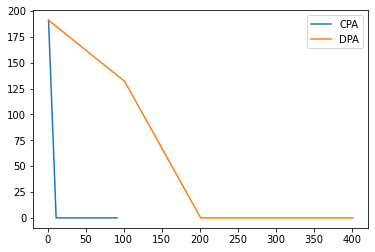

In [202]:
plt.figure()

key = bytearray(key_list)

xc = range(1, 100, 10)
yc = [rank_cpa_byte(key, 0, traces[:nb,:], messages[:nb,:]) for nb in xc]
plt.plot(xc, yc, label="CPA")

xd = range(1, 500, 100)
yd = [rank_dpa_byte(key, 0, traces[:nb,:], messages[:nb,:]) for nb in xd]
plt.plot(xd, yd, label="DPA")

plt.legend()
plt.show()